In [1]:
# %% [markdown]
# Retrieval system using HOG descriptors + mAP@1 and mAP@5
# This notebook:
# 1. Builds (or loads) HOG descriptors for the database (BBDD)
# 2. Extracts HOG for the query images
# 3. Retrieves the most similar database images using cosine similarity
# 4. Evaluates using mAP@1 and mAP@5 based on gt_corresps.pkl

# %%
import os
import cv2
import numpy as np
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from noise_filter import preprocess_image
import background_remover_w2 as background_remover
from image_split import split_images
from image_split_team5 import segment_multiple_paintings
import matplotlib.pyplot as plt

# --- paths (adjust to your structure) ---
QUERY_FOLDER = "../Data/Week4/qsd1_w4/"     # query images
DB_FOLDER    = "../Data/BBDD/"        # database (gallery) images
GT_PATH      = "../Data/Week4/qsd1_w4/gt_corresps.pkl"


os.makedirs("results", exist_ok=True)


In [2]:
def load_images_from_folder(folder):
    """
    Loads all .jpg/ images from a folder, sorted by filename.
    Returns:
        names: list of filenames
        imgs:  list of loaded cv2 images
    """
    names = sorted(
        [
            f
            for f in os.listdir(folder)
            if f.lower().endswith((".jpg"))
        ]
    )
    imgs = []
    for name in names:
        path = os.path.join(folder, name)
        img = cv2.imread(path)
        if img is None:
            print(f"⚠️ Could not read {path}")
            continue
        imgs.append(img)
    return names, imgs


def precision_at_k(retrieved_indices, gt_indices, k):
    """
    Compute precision@k for one query.

    retrieved_indices: list of database indices sorted by similarity (best first)
    gt_indices: list of correct database indices for that query (can be 1 or more)
    k: cutoff (1, 5, ...)

    precision@k = (# of retrieved items in top-k that are in GT) / k
    """
    retrieved_k = retrieved_indices[:k]
    hits = sum(1 for r in retrieved_k if r in gt_indices)
    return hits / k


def mean_average_precision_at_k(all_retrieved, all_gts, k):
    """
    Compute mean precision@k over all queries.
    (Many assignments call this mAP@k when GT is small.)
    """
    assert len(all_retrieved) == len(all_gts)
    precisions = []
    for retrieved, gts in zip(all_retrieved, all_gts):
        p = precision_at_k(retrieved, gts, k)
        precisions.append(p)
    return np.mean(precisions)

def validate_split(is_split, imgs, min_size_ratio=0.2):
    """
    Validate the result of segment_multiple_paintings.

    Parameters:
        is_split (bool): Whether the segmentation said it's split.
        imgs (list or np.ndarray): List [img1, img2] or a single image.
        min_size_ratio (float): Minimum ratio (relative to original image width/height)
                                for a crop to be considered valid.
    Returns:
        (bool, list or np.ndarray): same format as input but corrected.
    """
    # If no split, nothing to do
    if not is_split:
        return False, imgs

    # If there are not exactly 2 images, return as not split
    if not isinstance(imgs, (list, tuple)) or len(imgs) != 2:
        return False, imgs

    img1, img2 = imgs

    # Compute relative sizes compared to original (assume same height)
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    total_width = w1 + w2
    total_height = max(h1, h2)

    # Check each crop relative to the original combined width
    valid_left  = w1 / total_width  > min_size_ratio
    valid_right = w2 / total_width  > min_size_ratio
    valid_height1 = h1 / total_height > min_size_ratio
    valid_height2 = h2 / total_height > min_size_ratio

    # Only keep crops that are not too small
    valid_imgs = []
    if valid_left and valid_height1:
        valid_imgs.append(img1)
    if valid_right and valid_height2:
        valid_imgs.append(img2)

    # Decide if it's still a valid split
    if len(valid_imgs) == 2:
        return True, valid_imgs
    elif len(valid_imgs) == 1:
        # Only one valid crop left → treat as not split
        return False, valid_imgs[0]
    else:
        # none valid? probably invalid segmentation
        return False, imgs



In [3]:
def compute_hog_descriptor(
    img_bgr,
    size=(128, 128),
    cell=(4, 4),
    block=(16, 16),
    block_stride=(8, 8),
    nbins=9,
):
    """
    Compute a HOG descriptor for a BGR image.
    We:
    1. convert to grayscale
    2. resize to a fixed size so all descriptors have the same length
    3. compute HOG
    4. L2-normalize the final vector
    """
    # 1) BGR -> Gray
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # 2) fixed resize to make descriptor length stable
    gray = cv2.resize(gray, size)

    # 3) create HOG object with consistent parameters
    hog = cv2.HOGDescriptor(
        _winSize=size,
        _blockSize=block,
        _blockStride=block_stride,
        _cellSize=cell,
        _nbins=nbins,
    )
    desc = hog.compute(gray)  # shape (N, 1)
    desc = desc.flatten().astype(np.float32)

    # 4) L2 normalization (good for cosine and distance-based retrieval)
    norm = np.linalg.norm(desc)
    if norm > 0:
        desc = desc / norm

    return desc

In [4]:
def compute_sift_desc(img_bgr, nfeatures=1200, rootsift=False, img_name=""):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(nfeatures=nfeatures)
    _, des = sift.detectAndCompute(gray, None)
    if des is None:
        print(f"⚠️ Warning: No SIFT descriptors found for {img_name}.")
        return None
    des = des.astype(np.float32)
    if rootsift:
        des /= (des.sum(axis=1, keepdims=True) + 1e-12)
        des = np.sqrt(des, out=des)
    return des

In [5]:
# %% 
# 1. Build or load database descriptors
# # where to store precomputed DB descriptors
descriptor = "SIFT"
DESC_DB_PATH = "results/descriptors_db_sift.pkl"

if os.path.exists(DESC_DB_PATH):
    print(f"✅ Loading DB descriptors from {DESC_DB_PATH}")
    with open(DESC_DB_PATH, "rb") as f:
        data = pickle.load(f)
        db_descs = data["desc_gt"]    # list of numpy arrays
        db_names = data["gt_names"]   # list of image filenames
else:
    print(f"🧠 Computing {descriptor} descriptors for database images...")
    db_names, db_imgs = load_images_from_folder(DB_FOLDER)
    db_descs = []
    for img, name in zip(db_imgs, db_names):
        print("Processing image",name)
        if descriptor == "SIFT":
            d = compute_sift_desc(img, rootsift=True, img_name=name)
        elif descriptor == "HOG":   
            d = compute_hog_descriptor(img)
        db_descs.append(d)

    # store only numpy arrays (serializable) → no cv2.KeyPoint here
    with open(DESC_DB_PATH, "wb") as f:
        pickle.dump({"desc_gt": db_descs, "gt_names": db_names}, f)
    print(f"✅ Saved DB descriptors to {DESC_DB_PATH}")


✅ Loading DB descriptors from results/descriptors_db_sift.pkl


In [6]:
# %%
# 2. Load query images and ground-truth correspondences

print("📥 Loading query images...")
q_names, q_imgs = load_images_from_folder(QUERY_FOLDER)

print("📥 Loading ground-truth correspondences...")
with open(GT_PATH, "rb") as f:
    gt_corresps = pickle.load(f)   # e.g. [[236], [107], [280, 285], ...]
print(f"→ {len(gt_corresps)} GT entries loaded")


📥 Loading query images...
📥 Loading ground-truth correspondences...
→ 30 GT entries loaded


In [7]:
desc_query = []   # list of [desc_left, desc_right] or [desc_single]

print(f"🧠 Computing {descriptor} for queries...")
for img, img_name in zip(q_imgs, q_names):
    img = preprocess_image(img)
    bool_split, splitted_imgs = segment_multiple_paintings(img)
    ok_split, parts = validate_split(bool_split, splitted_imgs)

    if ok_split:
        left_artwork, right_artwork = parts
        iml, left_mask, *_ = background_remover.remove_background_morphological_gradient(left_artwork)
        imr, right_mask, *_ = background_remover.remove_background_morphological_gradient(right_artwork)

        left_cropped  = background_remover.crop_to_mask_rectangle(left_artwork, left_mask)
        right_cropped = background_remover.crop_to_mask_rectangle(right_artwork, right_mask)

        if descriptor == "SIFT":
            desc_left  = compute_sift_desc(left_cropped,  rootsift=True)
            desc_right = compute_sift_desc(right_cropped, rootsift=True)
        else:
            raise ValueError("Only SIFT in this baseline")

        # keep consistent list structure
        desc_query.append([desc_left, desc_right])

    else:
        im, mask, *_ = background_remover.remove_background_morphological_gradient(img)
        cropped = background_remover.crop_to_mask_rectangle(img, mask)
        desc_single = compute_sift_desc(cropped, rootsift=True)
        desc_query.append([desc_single])  # still a list


🧠 Computing SIFT for queries...


## With no unknown artworks detection

In [83]:
from tqdm import tqdm
# --- FLANN 2-NN + Lowe ratio; returns "good match count" ---
_flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=8),
                               dict(checks=64))

def good_match_count(desQ, desD, ratio=0.76):
    if desQ is None or desD is None or len(desQ)==0 or len(desD)==0:
        return 0
    knn = _flann.knnMatch(desQ, desD, k=2)
    good = 0
    for m, n in knn:
        if m.distance < ratio * n.distance:
            good += 1
    return good

def rank_db_for_query_multi(desc_crops, db_descs, ratio=0.76):
    """
    desc_crops: list of descriptor arrays for this query (len=1 or 2)
    db_descs:   list of descriptor arrays (one per DB image)
    returns:    ranked list of (db_idx, score) sorted desc by score
    """
    scores = []
    for i, desD in enumerate(db_descs):
        best = 0
        for desQ in desc_crops:  # MAX merge across crops
            c = good_match_count(desQ, desD, ratio)
            if c > best:
                best = c
        scores.append((i, best))
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores  # full ranking

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.

    This function computes the average prescision at k between two lists of
    items.

    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The average precision at k over the input lists

    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10, skip_unknown=True):
    """
    Computes the mean average precision at k.

    This function computes the mean average prescision at k between two lists
    of lists of items.

    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns
    -------
    score : double
            The mean average precision at k over the input lists

    """
    map_score = 0.0
    total_pics = 0
    for idx, p in enumerate(predicted):
        if len(p) == 2:
            # print(f"actual[idx]: {actual[idx]}, {actual[idx][0]}, {actual[idx][1]}")
            apk_score1 = apk([actual[idx][0]], p[0], k)
            apk_score2 = apk([actual[idx][1]], p[1], k)
            map_score += apk_score1 + apk_score2
            total_pics += 2
            ### HERE WE SHOULD AVERAGE THE TWO SCORES?
            # print(f"Scores for query {idx}: Left AP@{k}={apk_score1:.4f}, Right AP@{k}={apk_score2:.4f}")
        elif actual[idx] == [-1] and skip_unknown:
            print(f"Scores for query {idx}: Unknown artwork, skipped.")
            continue
        else:
            apk_score1 = apk(actual[idx], p, k)
            map_score += apk_score1
            total_pics += 1
            # print(f"Scores for query {idx}: Single AP@{k}={apk_score1:.4f}")

    return map_score / total_pics if total_pics > 0 else 0.0

def compute_map_at_k(desc_query, db_descs, gt_corresps, ratio=0.76):
    """
    desc_query:  list where each element is [desc_single] or [desc_left, desc_right]
    db_descs:    list of descriptor arrays, one per DB image
    gt_corresps: list; each entry is an int, list of ints, or [-1]
    """
    predicted = []
    # for qi, desc_crops in tqdm(enumerate(desc_query), total=len(desc_query)):
    for qi, desc_crops in enumerate(desc_query):
        # Normalize GT format
        q_gt = gt_corresps[qi]
        if len(q_gt) == 2 and len(desc_crops) == 2:
            # relevants = [g for g in q_gt if g != -1]
            list_ranked_indices = []
            for desc_crop in desc_crops:
                ranked = rank_db_for_query_multi([desc_crop], db_descs, ratio=ratio)
                ranked_indices, ranked_scores = zip(*ranked)
                list_ranked_indices.append(ranked_indices)
                #print all: ranked_indices, ranked_scores, gt... of the first 10 ranked
                for i in range(min(1, len(ranked_indices))):
                    print(f"Rank {i+1}: DB Index={ranked_indices[i]}, Score={ranked_scores[i]}")
                    print(f"GT for query {qi}: {q_gt}")

        else:
            ranked = rank_db_for_query_multi(desc_crops, db_descs, ratio=ratio)
            list_ranked_indices, list_ranked_scores = zip(*ranked)
            #print all: ranked_indices, ranked_scores, gt... of the first 10 ranked
            for i in range(min(1, len(list_ranked_indices))):
                print(f"Rank {i+1}: DB Index={list_ranked_indices[i]}, Score={list_ranked_scores[i]}")
                print(f"GT for query {qi}: {q_gt}")
        
        predicted.append(list_ranked_indices)
    
    return predicted

# pred = compute_map_at_k(desc_query, db_descs, gt_corresps, ratio=0.76)    
# map5 = mapk(gt_corresps, pred, k=5)
# map1 = mapk(gt_corresps, pred, k=1)

# print(f"✅ mAP@1 = {map1:.4f}")
# print(f"✅ mAP@5 = {map5:.4f}")

In [79]:
pred = compute_map_at_k(desc_query, db_descs, gt_corresps, ratio=0.76)    
map5 = mapk(gt_corresps, pred, k=5, skip_unknown=False)
map1 = mapk(gt_corresps, pred, k=1, skip_unknown=False)

print(f"✅ mAP@1 = {map1:.4f}")
print(f"✅ mAP@5 = {map5:.4f}")

✅ mAP@1 = 0.6667
✅ mAP@5 = 0.6731


In [77]:
# pred = compute_map_at_k(desc_query, db_descs, gt_corresps, ratio=0.76)    
map5 = mapk(gt_corresps, pred, k=5)
map1 = mapk(gt_corresps, pred, k=1)

print(f"✅ mAP@1 = {map1:.4f}")
print(f"✅ mAP@5 = {map5:.4f}")

Scores for query 0: Unknown artwork, skipped.
Scores for query 7: Unknown artwork, skipped.
Scores for query 11: Unknown artwork, skipped.
Scores for query 12: Unknown artwork, skipped.
Scores for query 14: Unknown artwork, skipped.
Scores for query 17: Unknown artwork, skipped.
Scores for query 19: Unknown artwork, skipped.
Scores for query 21: Unknown artwork, skipped.
Scores for query 26: Unknown artwork, skipped.
Scores for query 29: Unknown artwork, skipped.
Scores for query 0: Unknown artwork, skipped.
Scores for query 7: Unknown artwork, skipped.
Scores for query 11: Unknown artwork, skipped.
Scores for query 12: Unknown artwork, skipped.
Scores for query 14: Unknown artwork, skipped.
Scores for query 17: Unknown artwork, skipped.
Scores for query 19: Unknown artwork, skipped.
Scores for query 21: Unknown artwork, skipped.
Scores for query 26: Unknown artwork, skipped.
Scores for query 29: Unknown artwork, skipped.
✅ mAP@1 = 0.8966
✅ mAP@5 = 0.9052


## With unknown artworks detection

In [ ]:
import cv2, numpy as np
from typing import List, Tuple, Union


# ---------- Matching primitives ----------

_flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=8),
                               dict(checks=64))

def good_match_count(desQ: Union[np.ndarray, None],
                     desD: Union[np.ndarray, None],
                     ratio: float = 0.76) -> int:
    """
    2-NN + Lowe ratio test. Returns number of 'good' matches.
    """
    if desQ is None or desD is None or len(desQ) == 0 or len(desD) == 0:
        return 0
    knn = _flann.knnMatch(desQ, desD, k=2)
    good = 0
    for m, n in knn:
        if m.distance < ratio * n.distance:
            good += 1
    return good

def rank_db_with_scores(desQ: np.ndarray,
                        db_descs: List[np.ndarray],
                        ratio: float = 0.76) -> List[Tuple[int, int]]:
    """
    Returns list sorted desc by score: [(db_idx, good_match_count), ...]
    """
    scores = []
    for i, desD in enumerate(db_descs):
        c = good_match_count(desQ, desD, ratio)
        scores.append((i, c))
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores

def decide_unknown_from_scores(scores: List[Tuple[int,int]],
                               T_abs: int = 12,
                               T_ratio: float = 1.4) -> bool:
    """
    Unknown if:
      - low absolute matches (best < T_abs), OR
      - no clear winner (best/second < T_ratio)
    """
    if not scores:
        return True
    best = scores[0][1]
    second = scores[1][1] if len(scores) > 1 else 0
    if best < T_abs:
        return True
    if second > 0 and (best / (second + 1e-9)) < T_ratio:
        return True
    return False

# ---------- Prediction (your shape preserved) ----------

def predict_with_unknowns(desc_query: List[List[Union[np.ndarray, None]]],
                          db_descs: List[np.ndarray],
                          topK: int = 10,
                          ratio: float = 0.76,
                          T_abs: int = 12, T_ratio: float = 1.4):
    """
    Keeps your output shape:
      - single artwork: [ [db_idx0, db_idx1, ...] ]  or [[-1]]
      - two artworks:   [ [rank_left...], [rank_right...] ]  (each may be [-1])
    """
    predictions = []
    for desc_crops in desc_query:
        crop_preds = []
        for desQ in desc_crops:
            if desQ is None or len(desQ) == 0:
                crop_preds.append([-1])
                continue
            scores = rank_db_with_scores(desQ, db_descs, ratio=ratio)
            ranked_indices = [i for i, _ in scores]
            if decide_unknown_from_scores(scores, T_abs=T_abs, T_ratio=T_ratio):
                crop_preds.append([-1])
            else:
                crop_preds.append(ranked_indices[:topK])
        predictions.append(crop_preds)
    return predictions


# ---------- Evaluation (robust to split≠GT) ----------
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10, skip_unknown=True):
    """
    Robust to 1↔2 splits:
      - 1 GT vs 2 preds: take BEST of the two
      - 2 GT vs 2 preds: best pairing average
      - 2 GT vs 1 pred: evaluate one list vs both GTs
      - GT [-1]: skip or count as 0 (depending on skip_unknown)
    """
    map_score = 0.0
    total_pics = 0
    for idx, p in enumerate(predicted):
        if len(p) == 2:
            if len(actual[idx]) == 2:
                apk_score1 = apk([actual[idx][0]], p[0], k)
                apk_score2 = apk([actual[idx][1]], p[1], k)
                map_score += apk_score1 + apk_score2
                total_pics += 2
            else:
                apk_score1 = apk(actual[idx], p[0], k)
                map_score += apk_score1
                total_pics += 1
        elif actual[idx] == [-1] and skip_unknown:
            print(f"Scores for query {idx}: Unknown artwork, skipped.")
            continue
        else:
            apk_score1 = apk(actual[idx], p, k)
            map_score += apk_score1
            total_pics += 1

    return map_score / total_pics if total_pics > 0 else 0.0


In [116]:
pred = predict_with_unknowns(desc_query, db_descs, topK=10, ratio=0.76, T_abs=12, T_ratio=1.4)
map5 = mapk(gt_corresps, pred, k=5,  skip_unknown=False)
map1 = mapk(gt_corresps, pred, k=1,  skip_unknown=False)
print(f"✅ mAP@1 = {map1:.4f}")
print(f"✅ mAP@5 = {map5:.4f}")

✅ mAP@1 = 0.4359
✅ mAP@5 = 0.4359


### New version with changed matching strategy and unknown artworks detection

In [ ]:
# ---------- (B1) ratio test + MUTUAL (cross-check) ----------
def mutual_ratio_matches(desQ, desD, ratio=0.76, flann=None):
    """Return list of mutual matches after Lowe ratio test."""
    if desQ is None or desD is None or len(desQ)==0 or len(desD)==0:
        return []

    flann = flann or _flann
    knn_qd = flann.knnMatch(desQ, desD, k=2)
    knn_dq = flann.knnMatch(desD, desQ, k=2)

    # forward keepers
    fwd = []
    for m,n in knn_qd:
        if m.distance < ratio * n.distance:
            fwd.append((m.queryIdx, m.trainIdx, m.distance))

    # backward best index map (after ratio)
    back_best = {}
    for m,n in knn_dq:
        if m.distance < ratio * n.distance:
            back_best[m.queryIdx] = (m.trainIdx, m.distance)

    # mutual keepers
    mutual = []
    for qi, di, d in fwd:
        bb = back_best.get(di, None)
        if bb is not None and bb[0] == qi:
            mutual.append((qi, di, d))
    return mutual

# ---------- (B2) scoring options ----------
def score_count(mutual):
    """Plain count of mutual ratio matches."""
    return len(mutual)

def score_norm_count(mutual, nQ, nD):
    """Normalize by available descriptors to avoid bias."""
    return len(mutual) / max(1, min(nQ, nD))

def score_ratio_margin(mutual, knn_qd):
    """
    Average 'margin' of accepted matches: 1 - dist1/dist2.
    Larger is better (more confident matches).
    """
    margins = []
    # build a set of accepted (qi->di) for speed
    keep = {(qi, di) for qi, di, _ in mutual}
    for pair in knn_qd:
        if len(pair) < 2: 
            continue
        m, n = pair
        if (m.queryIdx, m.trainIdx) in keep and n.distance > 1e-9:
            margins.append(1.0 - (m.distance / n.distance))
    if not margins:
        return 0.0
    return float(np.mean(margins))

def score_dist_weighted(mutual, sigma=200.0):
    """
    Distance-weighted evidence: sum exp(-d^2/sigma^2).
    Gives more credit to closer matches than far ones.
    """
    if not mutual:
        return 0.0
    dists = np.array([d for (_,_,d) in mutual], dtype=np.float32)
    w = np.exp(-(dists*dists) / (sigma*sigma))
    return float(w.sum())

def score_query_vs_db(desQ, desD, ratio=0.76, mode="norm_count", sigma=200.0):
    """
    Returns (score, aux) where:
      - score: chosen scalar similarity
      - aux: dict with extras for unknown detection (best, second, etc.)
    """
    # precompute knn for margin score only once
    knn_qd = _flann.knnMatch(desQ, desD, k=2) if (desQ is not None and desD is not None and len(desQ)>0 and len(desD)>0) else []
    mutual = mutual_ratio_matches(desQ, desD, ratio=ratio, flann=_flann)
    nQ = 0 if desQ is None else len(desQ)
    nD = 0 if desD is None else len(desD)

    if mode == "count":
        s = score_count(mutual)
    elif mode == "norm_count":
        s = score_norm_count(mutual, nQ, nD)
    elif mode == "ratio_margin":
        s = score_ratio_margin(mutual, knn_qd)
    elif mode == "dist_weighted":
        s = score_dist_weighted(mutual, sigma=sigma)
    else:
        raise ValueError("Unknown score mode")

    return s, {"mutual": len(mutual), "nQ": nQ, "nD": nD}

def rank_db_with_scores_v2(desQ, db_descs, ratio=0.76, mode="norm_count", sigma=200.0):
    scores = []
    for i, desD in enumerate(db_descs):
        s, aux = score_query_vs_db(desQ, desD, ratio=ratio, mode=mode, sigma=sigma)
        scores.append((i, s))
    scores.sort(key=lambda x: x[1], reverse=True)
    return scores

def decide_unknown_adaptive(ranked_vals, T_abs=0.15, T_ratio=1.15, adaptive=True, M=20, alpha=2.0):
    """
    ranked_vals: list of similarity scores (descending)
    For normalized scores (e.g., norm_count), typical magnitudes are ~0..1.
    Unknown if:
      - best < T_abs  (weak absolute evidence), OR
      - best/second < T_ratio  (no clear winner), OR
      - adaptive: best < mu + alpha*sigma of impostors (no standout over impostors)
    """
    if not ranked_vals:
        return True

    best   = ranked_vals[0]
    second = ranked_vals[1] if len(ranked_vals) > 1 else 0.0

    # absolute floor on normalized score
    if best < T_abs:
        return True

    # winner margin
    if second > 0 and (best / (second + 1e-9)) < T_ratio:
        return True

    if adaptive and len(ranked_vals) > 2:
        impostors = ranked_vals[1:1+M]
        mu = float(np.mean(impostors))
        sd = float(np.std(impostors)) + 1e-9
        if best < (mu + alpha * sd):
            return True

    return False

def predict_with_unknowns(desc_query, db_descs, topK=10, ratio=0.76,
                          T_abs=0.15, T_ratio=1.15,
                          mode="norm_count", sigma=200.0,
                          adaptive=True):
    """
    mode: "norm_count" (recommended), "count", "ratio_margin", "dist_weighted"
    adaptive: enable per-query adaptive thresholding (see section C)
    """
    predictions = []
    for desc_crops in tqdm(desc_query, desc="Predicting"):
        crop_preds = []
        for desQ in desc_crops:
            if desQ is None or len(desQ) == 0:
                crop_preds.append([-1]); continue

            scores = rank_db_with_scores_v2(desQ, db_descs, ratio=ratio, mode=mode, sigma=sigma)
            ranked_indices = [i for i, _ in scores]
            ranked_vals    = [s for _, s in scores]

            if decide_unknown_adaptive(ranked_vals, T_abs=T_abs, T_ratio=T_ratio, adaptive=adaptive):
                crop_preds.append([-1])
            else:
                crop_preds.append(ranked_indices[:topK])
        predictions.append(crop_preds)
    return predictions


In [119]:
pred = predict_with_unknowns(
    desc_query, db_descs, topK=10,
    ratio=0.76,
    T_abs=0.15, T_ratio=1.15,       # these are for normalized score
    mode="norm_count", sigma=200.0, # try also "dist_weighted" later
    adaptive=True
)
map5 = mapk(gt_corresps, pred, k=5,  skip_unknown=False)
map1 = mapk(gt_corresps, pred, k=1,  skip_unknown=False)
print(f"mAP@1={map1:.4f}  mAP@5={map5:.4f}")


mAP@1=0.3846  mAP@5=0.3846


In [120]:
pred_dist_weighted = predict_with_unknowns(
    desc_query, db_descs, topK=10,
    ratio=0.76,
    T_abs=0.15, T_ratio=1.15,       # these are for normalized score
    mode="dist_weighted", sigma=200.0,
    adaptive=True
)

map5 = mapk(gt_corresps, pred, k=5,  skip_unknown=False)
map1 = mapk(gt_corresps, pred, k=1,  skip_unknown=False)
print(f"mAP@1={map1:.4f}  mAP@5={map5:.4f}")


mAP@1=0.3846  mAP@5=0.3846


### Hyperparameter tuning results

Hyperparameter sweep: 100%|█| 8/8 [45:30<00:00, 341.35s/it, ratio=0.8, T_abs=24, T_ratio=1.8, mAP=0.



Best mAP@5: 0.4679  (ratio=0.72, T_abs=8, T_ratio=1.2)


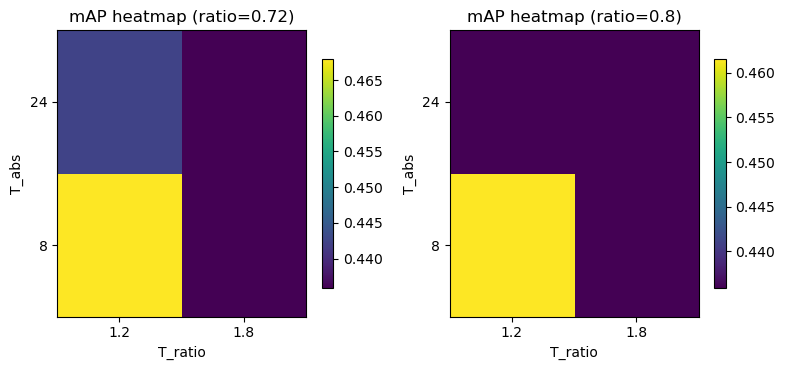

Final with best hparams:
mAP@1: 0.4358974358974359
mAP@5: 0.4423076923076923


In [117]:
import itertools, matplotlib.pyplot as plt
from tqdm import tqdm

def sweep_hparams(desc_query, db_descs, gt_corresps,
                  ratios=(0.72, 0.74, 0.76, 0.78, 0.80),
                  T_abss=(8, 12, 16, 20, 24),
                  T_ratios=(1.2, 1.3, 1.4, 1.6, 1.8),
                  k=5):
    """
    Grid-search sweep over ratio, T_abs, T_ratio.
    Shows tqdm progress over all combinations.
    """
    best = {"map": -1, "ratio": None, "T_abs": None, "T_ratio": None}
    per_ratio_grids = {}  # ratio -> 2D grid (T_abs x T_ratio)

    total_combos = len(ratios) * len(T_abss) * len(T_ratios)
    pbar = tqdm(total=total_combos, desc="Hyperparameter sweep", ncols=100)

    for r in ratios:
        grid = np.zeros((len(T_abss), len(T_ratios)), dtype=np.float32)
        for i, Ta in enumerate(T_abss):
            for j, Tr in enumerate(T_ratios):
                # --- Run retrieval and evaluation ---
                pred = predict_with_unknowns(desc_query, db_descs, topK=10,
                                             ratio=r, T_abs=Ta, T_ratio=Tr)
                score = mapk(gt_corresps, pred, k=k, skip_unknown=False)
                grid[i, j] = score

                # --- Track best ---
                if score > best["map"]:
                    best = {"map": score, "ratio": r, "T_abs": Ta, "T_ratio": Tr}

                # --- Update progress bar ---
                pbar.set_postfix({
                    "ratio": r,
                    "T_abs": Ta,
                    "T_ratio": Tr,
                    "mAP": f"{score:.3f}",
                    "best": f"{best['map']:.3f}"
                })
                pbar.update(1)

        per_ratio_grids[r] = grid

    pbar.close()
    print(f"\nBest mAP@{k}: {best['map']:.4f}  "
          f"(ratio={best['ratio']}, T_abs={best['T_abs']}, T_ratio={best['T_ratio']})")

    return best, per_ratio_grids, T_abss, T_ratios

def plot_heatmaps(per_ratio_grids, T_abss, T_ratios):
    n = len(per_ratio_grids)
    cols = min(3, n)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3.8*rows))
    axes = np.atleast_1d(axes).ravel()

    for ax, (ratio, grid) in zip(axes, per_ratio_grids.items()):
        im = ax.imshow(grid, origin='lower', aspect='auto')
        ax.set_xticks(range(len(T_ratios))); ax.set_xticklabels(T_ratios)
        ax.set_yticks(range(len(T_abss)));  ax.set_yticklabels(T_abss)
        ax.set_xlabel("T_ratio"); ax.set_ylabel("T_abs")
        ax.set_title(f"mAP heatmap (ratio={ratio})")
        fig.colorbar(im, ax=ax, shrink=0.8)

    # hide unused axes
    for ax in axes[len(per_ratio_grids):]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

best, grids, T_abss, T_ratios = sweep_hparams(
    desc_query, db_descs, gt_corresps,
    ratios=(0.72,0.80),
    T_abss=(8,24),
    T_ratios=(1.2,1.8),
    k=5
)
plot_heatmaps(grids, T_abss, T_ratios)

# Re-run with the best for your final metrics:
pred = predict_with_unknowns(desc_query, db_descs, topK=10,
                             ratio=best["ratio"], T_abs=best["T_abs"], T_ratio=best["T_ratio"])
print("Final with best hparams:")
print("mAP@1:", mapk(gt_corresps, pred, k=1,  skip_unknown=False))
print("mAP@5:", mapk(gt_corresps, pred, k=5,  skip_unknown=False))